# Machine Learning for Drug Discovery Research Literature Mining

We are interested in applications of machine learning to mine the research literature for additional types of entities/classes/answers relevant to drug discovery not already available to Open Targets which include but are not limited to variants, biomarkers, tissues/cell types, adverse events, and assay conditions. 

## Tasks
In this, you will need to develop an ML pipeline that involves:

1. Data Collection
2. Data Preprocessing (Visualization)
3. ML Model Development
4. Evaluation
5. Complexity of Models in Production

## Note:
This notebook contains code for collecting the dataset and preprocessing (Tasks 1 and 2). The dataset we designed from tasks 1 and 2 in this notebook is for a named entity recognition problem. You are welcome to use this code and modify it as you please. Alternatively, you could also use free-to-use publicly available datasets or collect your own data solve train an ML model to solve a classification or a Q&A types of problem. *So, please feel free to develop your custom dataset and work towards prototyping an ML model to identify the aforementioned entities/ or build your own custom-designed classes and solve a classification problem of relevance/ or any of the answers of relevance.*

## Important things to consider:
- Please use free Google Colab or Kaggle if you require GPU access.
- This task should not take more than 6 hours to solve.
- Achieving more than 60% F-score/accuracy on the dataset is *not a requirement*, and you are assessed based on the design choices and data science protocols you follow in solving this task.
- Once completed, please share your notebook as a zip file as *<firstname_lastname.zi>"*, including outputs and detailed comments.
- Feedback will be given on your notebook.

# FalconFrames Environment Setup

This guide will walk you through setting up the Python environment and installing the necessary libraries for the test.

## Prerequisites

Before you begin, ensure you have Python installed on your system. Python 3.7 or later is recommended.

## Setting Up the Environment

1. **Create a Python Virtual Environment:**

    Run the following command to create a new virtual environment named `falconframes_env` in your home directory.

    ```bash
    python -m venv ~/falconframes_env
    ```

2. **Activate the Virtual Environment:**

    Activate the virtual environment using the command below:

    ```bash
    source ~/falconframes_env/bin/activate
    ```

    > Note: On Windows, the activation command is different. Use `~/falconframes_env\Scripts\activate`.

## Installing Dependencies

With the virtual environment activated, install the required libraries using `pip`:

```bash
pip install notebook
pip install matplotlib
pip install lxml
pip install ipywidgets
```

## Jupyter Notebook Extensions
Enable the required Jupyter Notebook extensions:

```bash
jupyter nbextension enable --py widgetsnbextension
```

## Installing SciSpacy
Install SciSpacy and its dependencies:

```bash
pip install scispacy
pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_sm-0.5.3.tar.gz
```

## Usage
After installation, you can start using Jupyter Notebook for the FalconFrames project. Ensure the virtual environment is activated whenever you work on the project.

## Deactivating the Environment
When you're done, you can deactivate the virtual environment by running:

```bash
deactivate
```


In [19]:
# python -m venv ~/falconframes_env

# source ~/falconframes_env/bin/activate


# pip install notebook
# pip install matplotlib
# pip install lxml
# pip install ipywidgets

# jupyter nbextension enable --py widgetsnbextension

# pip install scispacy
# pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_sm-0.5.3.tar.gz


# Import libraries

In [18]:
import csv
import pandas as pd
from tqdm import tqdm
import concurrent.futures
import requests
from requests.compat import urljoin
import matplotlib.pyplot as plt
import glob
import os
import re
from bs4 import BeautifulSoup

from nltk.tokenize import sent_tokenize

# We will use scipacy for sentence segmentation and tokenisation
import spacy
nlp = spacy.load("en_core_sci_sm", disable=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"])
nlp.add_pipe("sentencizer")


# 1. Data Collection

In this scenario, we will use the Europe PMC Annotations API to collect our dataset. 

Please go to [Europe PMC](https://europepmc.org/).

## Click on the Developers -> Annotations API.

`GET /europepmc/annotations_api/annotationsBySectionAndOrType`

The types we are interested in for this particular task are:
- Gene Mutations (variants)
- Cell, Cell Line, and Organ Tissue (tissues/cell types)


![Get the annotations of the articles which have at least one annotation of a type inside an article. ](image_1.png)


`CursorMark`: for pagination of the result list. For the first request, you can omit the parameter or use the default value 0.0. For every following page, use the value of the returned `nextCursorMark` element.

`PageSize`: 4

```json
{
  "nextCursorMark": 5075.731130732,
  "cursorMark": 0,
  "articles": [
    {
      "source": "MED",
      "extId": "31211024",
      "pmcid": "PMC6555104",
      "annotations": [
        {
          "prefix": "ters\\n\\n\\nArthroplasty-",
          "exact": "Cervical",
          "postfix": "\\n\\nP001: Intravenous ",
          "tags": [
            {
              "name": "cervical region",
              "uri": "http://purl.obolibrary.org/obo/UBERON_0005434"
            }
          ],
          "id": "http://europepmc.org/article/PMC/PMC6555104#ontogene-48929a03efe26120b761762f82fa795c",
          "type": "Organ Tissue",
          "section": "Article (http://semanticscience.org/resource/SIO_001029)",
          "provider": "OntoGene"
        },
        // other annotations
      ]
    }
  ]
}

Using the nextCursorMark, we move forward collecting the datasets.

The exact is the entity we are interested in, and the prefix and postfix provide us with the context. 

In [3]:
def get_epmc_annotations():
    base_url = "https://www.ebi.ac.uk/europepmc/annotations_api/annotationsBySectionAndOrType"
    types = ['Gene Mutations', 'Cell', 'Cell Line', 'Organ Tissue']
    data_list = []  # List to store the data

    for annotation_type in tqdm(types, desc="Processing Types"):
        cursor_mark = "0.0"
        for _ in range(2):  # Iterate 2 times for each type
            params = {
                'type': annotation_type,
                'filter': 1,
                'format': 'JSON',
                'cursorMark': cursor_mark,
                'pageSize': 4
            }
            response = requests.get(base_url, params=params)
            if response.status_code == 200:
                data = response.json()
                cursor_mark = data['nextCursorMark']

                for article in data['articles']:
                    pmc_id = article.get('pmcid')
                    if not pmc_id:
                        continue  # Skip this article if 'pmcid' is not found

                    for annotation in article['annotations']:
                        exact = annotation.get('prefix', '') + annotation.get('exact', '') + annotation.get('postfix', '')
                        token = annotation['tags'][0]['name'] if annotation['tags'] else ''
                        ner = annotation['type']
                        data_list.append([pmc_id, exact, token, ner])
            else:
                print(f"Failed to fetch data for type {annotation_type} and cursor mark {cursor_mark}")

    annotations_df = pd.DataFrame(data_list, columns=['pmc_id', 'partial_sentence', 'token', 'ner'])
    return annotations_df




In [4]:
annotations_df = get_epmc_annotations()

rename_dict = {
    'Gene Mutations': 'GM',
    'Cell': 'CL',
    'Cell Line': 'CLine',
    'Organ Tissue': 'OT'
}

annotations_df['ner'] = annotations_df['ner'].map(rename_dict)

Processing Types: 100%|███████████████████████████| 4/4 [00:17<00:00,  4.41s/it]


In [5]:
annotations_df

,pmc_id,partial_sentence,token,ner
0,PMC3318213,arify the impact of H221Y mutation on drug re,H221Y,GM
1,PMC3318213,3 backbone plasmid. H221Y and (or) Y181C muta,H221Y,GM
2,PMC3318213,mid. H221Y and (or) Y181C mutations were reve,Y181C,GM
3,PMC3318213,"cted, including the K101Q series (K101Q/Y181C",K101Q,GM
4,PMC3318213,"g the K101Q series (K101Q/Y181C/H221Y, K101Q/",K101Q,GM
...,...,...,...,...
73128,PMC6849404,c disease involving vertebrobasilar circulatio...,vertebra,OT
73129,PMC6849404,th symptoms such as cortical blindness along wit,cortex,OT
73130,PMC6849404,ations which can be life threatening and dis,life cycle,OT
73131,PMC6849404,"ning and disabling.\nCortical blindness, recoveri",cortex,OT


### Check if the categerories are balanced?

ner
OT       47199
CL       14511
CLine    11290
GM         133
Name: count, dtype: int64


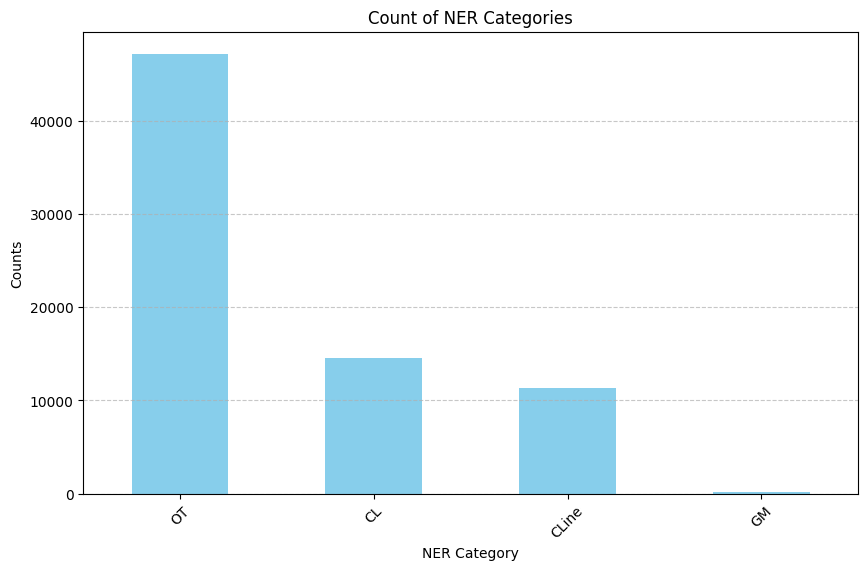

In [6]:
ner_counts = annotations_df['ner'].value_counts()
print(str(ner_counts))

plt.figure(figsize=(10, 6))
ner_counts.plot(kind='bar', color='skyblue')

plt.title('Count of NER Categories')
plt.xlabel('NER Category')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

#### Create a balanced DataFrame where each ner type has an equal number of samples.

In [7]:
# def balance_ner_samples(df):
#     min_count = df['ner'].value_counts().min()
#     balanced_df = df.groupby('ner').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
#     return balanced_df

# balanced_annotations_df = balance_ner_samples(annotations_df)

In [20]:
# Determine the count of the least common ner type and then randomly sample that number of rows for each ner type.
# This method fetches only 10 articles instead of 20 if we were to use the above method

def balance_ner_samples(df):
    min_count = df['ner'].value_counts().min()
    grouped = df.groupby('ner')

    selected_pmc_ids = set()
    balanced_df_list = []

    for name, group in grouped:
        # Try to select rows with pmc_ids already in selected_pmc_ids
        common_pmc_ids = group[group['pmc_id'].isin(selected_pmc_ids)]
        
        if len(common_pmc_ids) >= min_count:
            sample = common_pmc_ids.sample(min_count)
        else:
            remaining_count = min_count - len(common_pmc_ids)
            sample = pd.concat([common_pmc_ids, group[~group['pmc_id'].isin(selected_pmc_ids)].sample(remaining_count)])

        selected_pmc_ids.update(sample['pmc_id'].tolist())
        balanced_df_list.append(sample)

    balanced_df = pd.concat(balanced_df_list).reset_index(drop=True)
    return balanced_df

balanced_annotations_df = balance_ner_samples(annotations_df)


In [21]:
balanced_annotations_df

,pmc_id,partial_sentence,token,ner
0,PMC6833180,derived human CD34+ stem cells.\nFollowing eng...,stem cell,CL
1,PMC6833180,ecific mechanism of T cell evasion in AML\nShel,T cell,CL
2,PMC6833189,bone marrow-derived macrophages (BMDMs) and in...,macrophage,CL
3,PMC6833180,h peptide increased T cell infiltration in the,T cell,CL
4,PMC6833180,"is also present on neutrophils, which represe...",neutrophil,CL
...,...,...,...,...
527,PMC6763540,10 years.\nSentinel nodes in 6 cases were neg,primitive knot,OT
528,PMC6763540,should be driven by gastric cancer histotype.\nP,mucosa of stomach,OT
529,PMC6854655,"microstates, i.e., brain activity patterns,",brain,OT
530,PMC6854655,"as the respiratory sinus arrhythmia (RSA), w",sinoatrial node,OT


### Check if the categerories are balanced?

ner
CL       133
CLine    133
GM       133
OT       133
Name: count, dtype: int64


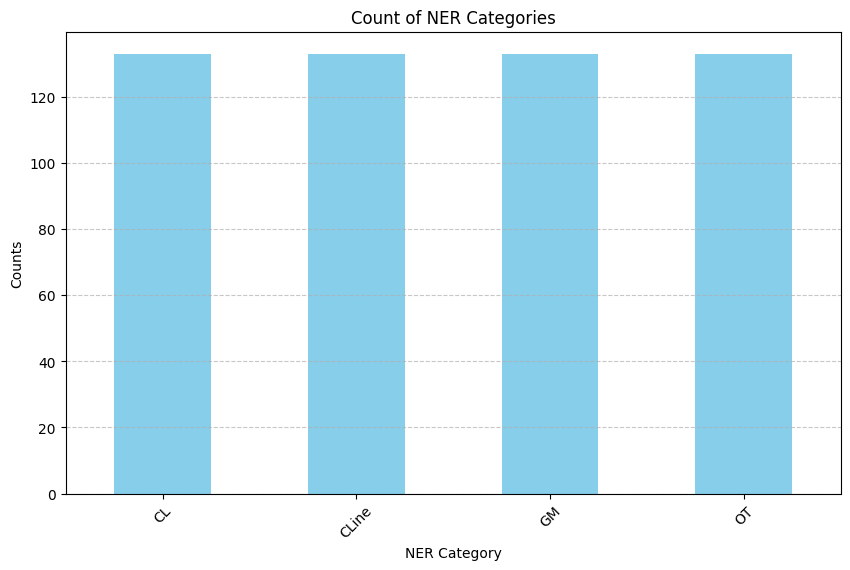

In [10]:
ner_counts = balanced_annotations_df['ner'].value_counts()
print(str(ner_counts))

plt.figure(figsize=(10, 6))
ner_counts.plot(kind='bar', color='skyblue')

plt.title('Count of NER Categories')
plt.xlabel('NER Category')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [11]:
unique_pmcids = balanced_annotations_df['pmc_id'].unique()
print(str(len(unique_pmcids)))

10


# 2. Data Preprocessing 

However, we cannot train our dataset using just the context but need the whole sentence/paragraph. For this purpose, we use the Europe PMC Article API to fetch the article using the PMCID we obtained from the annotations API and extract the whole sentence from the context.

In [22]:
def get_relevant_paragraphs(pmcid, partial_sentences):
    relevant_paragraphs = []
    url = f"https://www.ebi.ac.uk/europepmc/webservices/rest/{pmcid}/fullTextXML"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'lxml-xml')
        p_tags = soup.find_all('p')
        
        for tag in p_tags:
            paragraph_text = tag.get_text()
            if any(partial_sentence in paragraph_text for partial_sentence in partial_sentences):
                relevant_paragraphs.append(paragraph_text)

        return relevant_paragraphs
    else:
        return None

def segment_sentences_spacy(text):
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]

def get_full_text_xml_paragraphs(pmcid, partial_sentences):
    segmented_sentences = []
    relevant_paragraphs = get_relevant_paragraphs(pmcid, partial_sentences)

    if relevant_paragraphs:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            # Map the segment_sentences function to each paragraph
            results = executor.map(segment_sentences, relevant_paragraphs)

            for sentences in results:
                segmented_sentences.extend(sentences)

    return segmented_sentences

def find_sentence_with_substring(string_list, substring):
    for text in string_list:
        sentences = re.split(r'(?<=[.!?])\s+', text)
        for sentence in sentences:
            if substring in sentence:
                return sentence
    return None

def process_pmcid(df, pmcid, p_texts):
    sentences_data = {}
    for _, row in df[df['pmc_id'] == pmcid].iterrows():
        sentence = find_sentence_with_substring(p_texts, row['partial_sentence'])
        if sentence:
            token = row['token']
            start_span = sentence.find(token)
            end_span = start_span + len(token)

            if start_span != -1:  # Ensure the token is found in the sentence
                if sentence not in sentences_data:
                    sentences_data[sentence] = set()

                sentences_data[sentence].add((start_span, end_span, token, row['ner']))

    return [[pmcid, sentence, list(ner_tags)] for sentence, ner_tags in sentences_data.items()]


In [23]:
# this is time consuming. The sentenciser takes 1 minute per article on an average.
final_data = []

for pmcid in tqdm(unique_pmcids, desc="Processing PMCIDs"):
    partial_sentences = annotations_df[annotations_df['pmc_id'] == pmcid]['partial_sentence'].tolist()
    segmented_sentences = get_full_text_xml_paragraphs(pmcid, partial_sentences)
    processed_data = process_pmcid(annotations_df, pmcid, segmented_sentences)   
    if processed_data:
        final_data.extend(processed_data)

# Convert to DataFrame
final_df = pd.DataFrame(final_data, columns=['pmcid', 'sentence', 'ner'])

Processing PMCIDs: 100%|████████████████████████| 10/10 [09:47<00:00, 58.76s/it]


In [25]:
final_df.to_csv('final_df.csv', index=False)

In [26]:
final_df.sample(n=10)

,pmcid,sentence,ner
5270,PMC6763540,\nObjective: ALK encodes a tyrosine kinase rec...,"[(99, 103, lung, OT)]"
2836,PMC6501469,"Thus, we studied the effects of both polymorph...","[(70, 88, hippocampal neuron, CL)]"
3500,PMC6854655,After applying our inference procedure to thes...,"[(72, 86, pyramidal cell, CL)]"
4356,PMC6854655,A two-part computational model has been develo...,"[(68, 79, nerve fiber, OT)]"
6650,PMC6763540,Experiments were conducted using suspension of...,"[(47, 52, colon, OT), (54, 60, breast, OT)]"
3684,PMC6854655,Electrical activity in cortical networks and t...,"[(61, 67, neuron, CL)]"
299,PMC6833180,The infiltration immune cells beyond T cells h...,"[(37, 43, T cell, CL)]"
313,PMC6833180,RNAseq of tumor-associated myeloid cells was c...,"[(61, 66, MC-38, CLine), (27, 39, myeloid cell..."
2559,PMC6833189,Studies have identified C-C Motif Chemokine Li...,"[(54, 58, CCL4, CLine)]"
3963,PMC6854655,Integrate-and-fire neuron models are widely us...,"[(19, 25, neuron, CL)]"


### split the dataset into train, dev, and test.
Please train the dataset with selected your parameters and evaluate it on the dev set. Once you are happy with your evaluation, then evaluate the performance on the test set.

In [27]:
from sklearn.model_selection import train_test_split
train_size = 0.7
test_dev_size = 0.3
dev_size = 0.5  # Half of the test_dev_size, i.e., 15% of the total

train_df, test_dev_df = train_test_split(final_df, train_size=train_size, random_state=42)
test_df, dev_df = train_test_split(test_dev_df, test_size=dev_size, random_state=42)

In [28]:
dev_df.sample(n=10)

,pmcid,sentence,ner
1025,PMC6833180,"Consequently, by reducing tumor hypoxia in viv...","[(84, 90, T cell, CL)]"
4128,PMC6854655,A realistic large-scale model of the cerebellu...,"[(37, 47, cerebellum, OT)]"
1049,PMC6833180,"Specifically, we show that tumor microenvironm...","[(84, 90, T cell, CL)]"
5152,PMC6763540,"We compare the values, b1 and b1/b0, of coloni...","[(54, 60, tissue, OT), (40, 45, colon, OT)]"
6968,PMC6821132,"However, these assumptions have rarely been te...","[(117, 126, astrocyte, CL)]"
6196,PMC6763540,"There were also foci of mucocele-like changes,...","[(83, 89, stroma, OT)]"
5643,PMC6763540,Their presence may be due to displacement or s...,"[(63, 69, thymus, OT)]"
3710,PMC6854655,This framework can also be straightforwardly e...,"[(160, 174, pyramidal cell, CL), (70, 76, neur..."
4717,PMC6763540,The tumour cells had eosinophilic and oncocyti...,"[(21, 31, eosinophil, CL)]"
6978,PMC6821132,There is precedent for the notion that microgl...,"[(70, 79, phagocyte, CL)]"


### Convert the collected dataset into ML trainable format.

In [ ]:
def find_sub_span(token_span, entity_span):
    if token_span[0] < entity_span[1] and token_span[1] > entity_span[0]:
        return max(token_span[0], entity_span[0]), min(token_span[1], entity_span[1])
    return None

def convert2IOB(text, ner_tags):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    token_spans = [(token.idx, token.idx + len(token.text)) for token in doc]
    iob_tags = ['O'] * len(tokens)

    for entity in ner_tags:
        start, end, entity_token, entity_type = entity
        entity_flag = False
        for i, token_span in enumerate(token_spans):
            if find_sub_span(token_span, (start, end)):
                if not entity_flag:
                    iob_tags[i] = 'B-' + entity_type
                    entity_flag = True
                elif iob_tags[i] == 'O':
                    iob_tags[i] = 'I-' + entity_type
            else:
                entity_flag = False

    # Validate tag sequence
    for i in range(1, len(iob_tags)):
        if iob_tags[i].startswith('I-') and iob_tags[i-1] == 'O':
            raise ValueError(f"Invalid tag sequence: 'I-' tag follows 'O' tag at position {i}")

    return list(zip(tokens, iob_tags))

def process_df_and_write(df, writer):
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing rows"):
        text = row['sentence']
        ner_tags = row['ner']  # assuming ner column is a list of tuples
        iob_pairs = convert2IOB(text, ner_tags)
        for token, tag in iob_pairs:
            writer.writerow([token, tag])
        writer.writerow('')


In [ ]:
with open('train.tsv', 'w', newline='\n') as f1, \
     open('dev.tsv', 'w', newline='\n') as f2, \
     open('test.tsv', 'w', newline='\n') as f3:
    train_writer = csv.writer(f1, delimiter='\t', lineterminator='\n')
    dev_writer = csv.writer(f2, delimiter='\t', lineterminator='\n')
    test_writer = csv.writer(f3, delimiter='\t', lineterminator='\n')

    # Process each DataFrame and write to the corresponding file
    process_df_and_write(train_df, train_writer)
    process_df_and_write(dev_df, dev_writer)
    process_df_and_write(test_df, test_writer)

### 3. ML Learning Model Development
There is liberty in using any model you would like e.g., Classification or Question and Answering. However, the dataset here provides an NER task for ML training. 

### 4. Evaluation

In [ ]:
#tip: hyperparameter tuning

### 5. Complexity

In [ ]:
# tip: model compression or knowledge distillation to remove complexity in the inferebce time on production